<ol>
<li>Move Benchmark Results into Notebook</li>
<li>Measure on Different Array Sizes</li>
<li>Measure with different ranges for default values
<ul>
<li>Add the ability to generate data within a given range. How to avoid pigeonhole?</li>
<li>Hardcode new ranges as new distributions. Only need a few different ranges.</li>
</ul></li>
<li>Special case division with a shift. All my divisions are either multiplication or shifts. Run on different ranges.</li>
<li>SIMD to speed up one direction of search</li>
</ol>
<p>To generate the text files, use a makefile since it handles dependencies. To generate the output, use python to run the program. This separates concerns, and lets makefiles handle parallelism.</p>
<h1>Features</h1>
<ul>
<li>Add an option to compile a version that tracks the step count.</li>
<li>Add build options to control which search is being measured.</li>
<li>Makefile and benchmark scripts should operate across multiple sample files.</li>
</ul>
<h1>Questions</h1>
<ul>
<li>Methodology for measuring performance? I've been taking the best few iterations of many, many runs. Other work that I've seen drops the best runs and takes the middle. I think that the most interesting case is to average the best runs. With my current method, I'm tracking stats on all runs. This might be what's disrupting cache behavior. Use a heap instead of a vector, and only keep best items.</li>
</ul>
<h1>Insights</h1>
<p>I've learned that the random file generation results in files that vary wildly in terms of their applicability to interpolation search. A file where the average distance from the interpolation is 1.3% is 2.6x slower than a file with an average of 0.59%. Measure each file separately. Is there a good way to automate this?</p>
<p>This also explains why I didn't like using linear search before. If there's more perturbation, then linear search is much worse compared to less perturbation.</p>

In [4]:
# Execute commands from python.
# https://helloacm.com/execute-external-programs-the-python-ways/
import os
for line in os.popen('cat ./a.txt'):
    print("hi " + line.strip())

hi hello,
hi world


uniform_500,uniform_547,uniform_594,uniform_641,uniform_688,uniform_735,uniform_782,uniform_829,uniform_876,uniform_923,uniform_970
2.31613132944,1.84627020887,2.25239397049,3.82830677801,1.34473517735,3.33554312026,1.9194925167,2.70402454297,2.41216996331,1.92783534049,3.94925203387


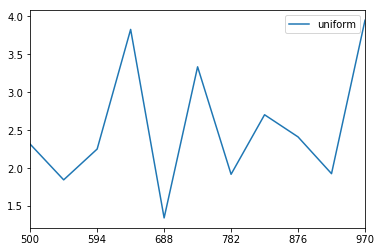

In [3]:
import os, numpy, pandas
import matplotlib.pyplot as plt
distributions = ['uniform']
sizes = [str(n) for n in range(500, 1000, 47)]
ok = os.system(
    "make profile; make input DISTRIBUTION='{}' ARRAY_SIZE='{}' -j".format(
        ' '.join(distributions),
        ' '.join(sizes)))
# run this in different commands so that the output is separated by plan
results = { d: { sz: 0.0 for sz in sizes } for d in distributions }
for d in distributions:
    for sz in sizes:
        isHeader = True
        best_runs = []
        for line in os.popen('./profile < input.{}.{}'.format(d, sz)):
            if not isHeader:
                bs_cycles, other_cycles = [float(s) for s in line.split(',')]
                best_runs.append(bs_cycles / other_cycles)
            isHeader = False
        results[d][sz] = numpy.mean(best_runs)
# write out the header
dist_sz = [[d, sz] for d in distributions for sz in sizes]
print(','.join(['_'.join(ds) for ds in dist_sz]))
print(','.join([str(results[d][sz]) for (d, sz) in dist_sz]))
df = pandas.DataFrame(results)
df.plot()
plt.show()

I've learned that different iterations of generating these random files can have a big impact on performance. 15000, 25000, 39000 cycles. This means my results might be much less dramatic, but I should average out each run over multiple test inputs.

In [81]:
files = ['input.uniform.1000.' + str(n) for n in range(30)]
os.system('make -j p1is ' + ' '.join(files))
cycles = [pandas.read_csv(os.popen('./p1is <' + file))['is'].mean()
         for file in files]
numbers = {file: [float(s)
                  for s in open(file).read().splitlines()[1:]]
           for file in files}

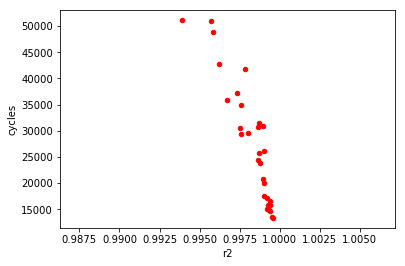

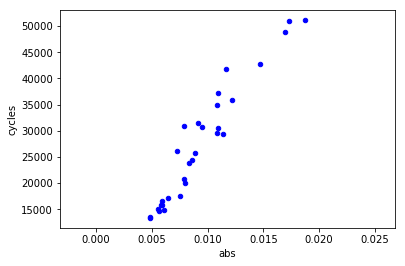

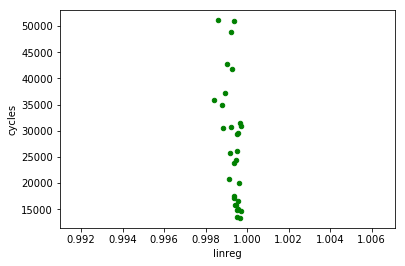

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [85]:
import sys, math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import linregress

slopes = {file: (len(numbers[file]) - 1) / (max(numbers[file]) - min(numbers[file]))
          for file in files}
mins = {file: min(numbers[file]) for file in files}
estimates = {file: [math.floor((x - mins[file]) * slopes[file])
            for x in numbers[file]]
             for file in files}
linreg = [linregress(range(len(numbers[file])), estimates[file])
         for file in files]
linreg = [r**2 for (_, _, r, _, _) in linreg]
r2_us = pandas.DataFrame({
    'files': files,
    'r2': [r2_score(range(len(numbers[file])), estimates[file])
      for file in files],
    'abs': [
        mean_absolute_error(
            range(len(numbers[file])),
            estimates[file])
        / len(numbers[file])
        for file in files],
    'linreg': linreg,
    'cycles': cycles })
plt.clf()
ax1 = r2_us.plot.scatter('r2', 'cycles', color='r')
r2_us.plot.scatter('abs', 'cycles', color='b')
r2_us.plot.scatter('linreg', 'cycles', color='g')
plt.show()
_, _, r2_r, _, _ = linregress(r2_us['r2'], r2_us['cycles']) 
_, _, abs_r, _, _ = linregress(r2_us['abs'], r2_us['cycles'])
_, _, linreg_r, _, _ = linregress(r2_us['linreg'], r2_us['cycles']])
print("R^2 : absolute error --> cycles = " + str(abs_r**2))
print("R^2 : R^2 --> cycles = " + str(r2_r**2))
print("R^2 : linreg --> cycles = " + str(linreg_r**2))
print(r2_us[['files', 'abs', 'cycles']].sort_values('abs'))

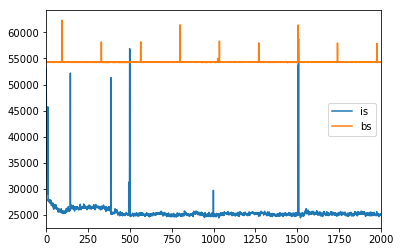

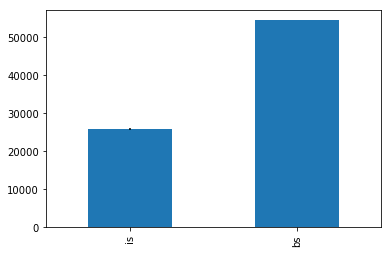

In [14]:
import os, pandas, math
import matplotlib.pyplot as plt
import numpy as np, scipy

N_LOAD = 2000
Z = 1.96 # Assume 95% confidence interval http://bit.ly/2qszG3k

os.system("make p2ibu; make input.uniform.1000.1")
p2ibu = pandas.read_csv(os.popen("./p2ibu 3000 < ./input.uniform.1000.1"))
hot = p2ibu.drop(range(N_LOAD))
errs = Z * hot.std() / math.sqrt(len(hot.index))

plt.clf()
# draw cold timings over time
p2ibu.drop(range(N_LOAD, len(p2ibu.index))).plot()

# draw hot timings with standard deviation
fig, ax = plt.subplots()
hot.mean().plot.bar(yerr=errs, ax=ax)
plt.show()